# Multivariate Survival Analysis

In the simplest form, for a defined unit of analysis, survival analysis seeks to understand the time it takes that unit to reach a specified event using only the time and an indicator of whether the event happened or not. This understanding crystallizes as a survival function $S(t)$. Since nothing other than time is used, these simple forms of analyses are called univarite analysis. The [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) is one of the most used and well understood univariate estimator. However, when it is desired to use other additional variables to model the survival function, a regression approach known as the [Cox-Proportional Hazard](https://en.wikipedia.org/wiki/Proportional_hazards_model) `CPH` model (Cox regression) is typically used. Other regression techniques like [linear regression](https://en.wikipedia.org/wiki/Linear_regression) cannot be used since there is censoring involved with survival data. Advanced and modern methods go beyond Cox regression and use [ensemble techniques](https://scikit-survival.readthedocs.io/en/stable/index.html). Moreover, [deep learning](https://github.com/jaredleekatzman/DeepSurv) has also been applied to multivariate survival analysis.

One should wonder what these survival models are predicting. In the case of typical regression, a scalar is the model's predictive output. On the other hand, for survival regressions, $S(t)$ is the predictive output. If you remember, $S(t)$ is the probability of surviving pass time $t$ given that you have survived up to $t$ and denoted as $P(T > t)$. Since the predictive outputs of regression and survival regression are different and there is censoring involved, performance measures of survival regression are different from other types of regression. For regression models, the mean absolute error `MAE` or root mean squared error `RMSE` are commonly used. On the other hand, for survival regression models, the [concordance-index](https://square.github.io/pysurvival/metrics/c_index.html) (c-index) is recommended. 

In this notebook, we will look at a few available APIs in Python that may be used for multivariate survival modeling. 

- [lifelines](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html)
- [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html#)
- [PySurvival](https://square.github.io/pysurvival/)

## Load data

We will use a dataset concerning the survival of government types.

In [1]:
from lifelines.datasets import load_dd

df = load_dd()[['un_region_name', 'democracy', 'regime', 'duration', 'observed']] \
    .assign(
        un_region_name=lambda d: d['un_region_name'].apply(lambda s: s.lower().replace(' ', '_').replace('-', '')),
        democracy=lambda d: d['democracy'].apply(lambda s: 1 if s == 'Democracy' else 0),
        regime=lambda d: d['regime'].apply(lambda s: s.lower().replace(' ', '_'))
    ) \
    .rename(columns={
        'un_region_name': 'region',
        'duration': 'T',
        'observed': 'E'
    })

df.shape

(1808, 5)

You will notice that there are two categorical variables. These are always a nuisance to handle as the algorithms that we are using will require categorical variables to be transformed into numeric ones.

In [2]:
df.dtypes

region       object
democracy     int64
regime       object
T             int64
E             int64
dtype: object

In [3]:
df.head()

,region,democracy,regime,T,E
0,southern_asia,0,monarchy,7,1
1,southern_asia,0,civilian_dict,10,1
2,southern_asia,0,monarchy,10,1
3,southern_asia,0,civilian_dict,5,0
4,southern_asia,0,civilian_dict,1,0


Looking at the region and regime variables, it's probably best to drop the one-hot encoded (dummy) columns corresponding to the values with the smallest frequencies.

In [4]:
df['region'].value_counts()

south_america                191
western_europe               164
southern_europe              161
northern_europe              148
western_asia                 142
western_africa               118
central_america              113
eastern_europe               103
southern_asia                 98
eastern_africa                91
caribbean                     86
southeastern_asia             81
eastern_asia                  68
middle_africa                 51
melanesia                     36
micronesia                    31
northern_africa               29
australia_and_new_zealand     25
southern_africa               25
northern_america              22
polynesia                     16
central_asia                   9
Name: region, dtype: int64

In [5]:
df['regime'].value_counts()

parliamentary_dem    585
civilian_dict        330
presidential_dem     327
mixed_dem            275
military_dict        236
monarchy              55
Name: regime, dtype: int64

## lifelines

Let's transform the data as appropriate.

In [6]:
import pandas as pd

Xy = pd.get_dummies(df) \
    .drop(columns=['region_central_asia', 'regime_monarchy'])

X = Xy[Xy.columns.drop(['T'])]
y = Xy['T']

Xy.shape, X.shape, y.shape

((1808, 29), (1808, 28), (1808,))

Now let's fit the models.

In [7]:
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import CoxPHFitter, LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

CoxRegression = sklearn_adapter(CoxPHFitter, event_col='E')
LogLogisticRegression = sklearn_adapter(LogLogisticAFTFitter, event_col='E')
WeibullRegression = sklearn_adapter(WeibullAFTFitter, event_col='E')
LogNormalRegression = sklearn_adapter(LogNormalAFTFitter, event_col='E')

ll_names = ['CoxPHFitter', 'LogLogisticAFTFitter', 'WeibullAFTFitter', 'LogNormalAFTFitter']
ll_models = [
    CoxRegression(penalizer=1e-5),
    LogLogisticRegression(penalizer=1e-5),
    WeibullRegression(penalizer=1e-5),
    LogNormalRegression(penalizer=1e-5),
]

for m in ll_models:
    m.fit(X, y)

The scores are based on the c-index which has a value in the range $[0, 1]$ where a value closer to 1 indicataes better predictive performance.

In [8]:
ll_scores = pd.Series({n: m.score(X, y) for n, m in zip(ll_names, ll_models)})
ll_scores

CoxPHFitter             0.647557
LogLogisticAFTFitter    0.669827
WeibullAFTFitter        0.639399
LogNormalAFTFitter      0.662717
dtype: float64

Here we plot $S(t)$ and $H(t)$ for the first unit.

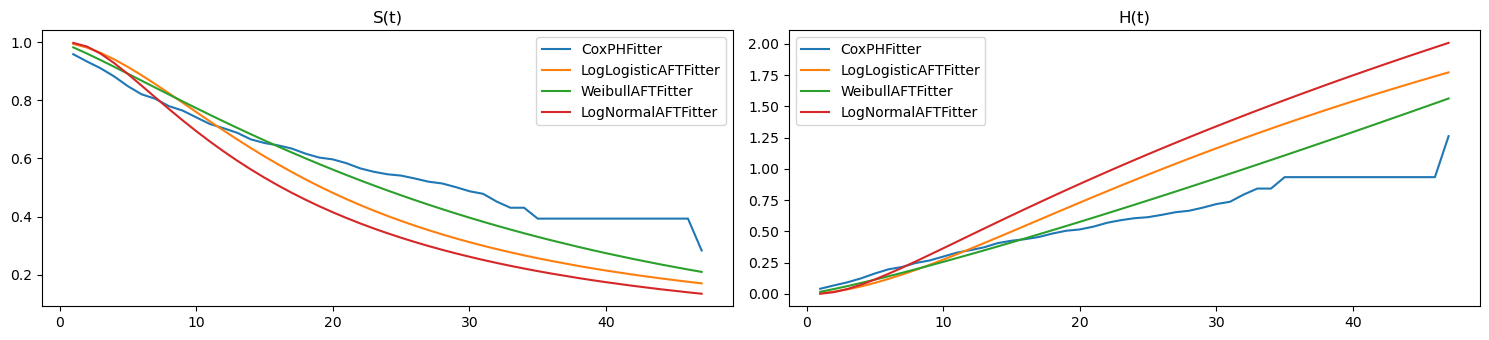

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

pd.DataFrame({n: m.lifelines_model.predict_survival_function(X)[0] 
              for n, m in zip(ll_names, ll_models)}) \
    .plot(kind='line', ax=ax[0])

pd.DataFrame({n: m.lifelines_model.predict_cumulative_hazard(X)[0] 
              for n, m in zip(ll_names, ll_models)}) \
    .plot(kind='line', ax=ax[1])

ax[0].set_title('S(t)')
ax[1].set_title('H(t)')

plt.tight_layout()

## scikit-survival

Let's transform the data for scikit-survival. The `y` for scikit-survival models is actually a tuple.

In [10]:
import numpy as np

X = Xy[Xy.columns.drop(['T', 'E'])] \
    .assign(democracy=lambda d: d['democracy'].astype(np.float32))
y = np.array([(e, t) for e, t in zip(Xy['E'], Xy['T'])], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

X.shape, y.shape

((1808, 27), (1808,))

In [11]:
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

ss_names = ['GradientBoostingSurvivalAnalysis', 'RandomSurvivalForest']
ss_models = [
    GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=37),
    RandomSurvivalForest(n_estimators=500, n_jobs=-1, random_state=37)
]

for m in ss_models:
    m.fit(X, y)

In [12]:
ss_scores = pd.Series({n: m.score(X, y) for n, m in zip(ss_names, ss_models)})
ss_scores

GradientBoostingSurvivalAnalysis    0.700963
RandomSurvivalForest                0.610181
dtype: float64

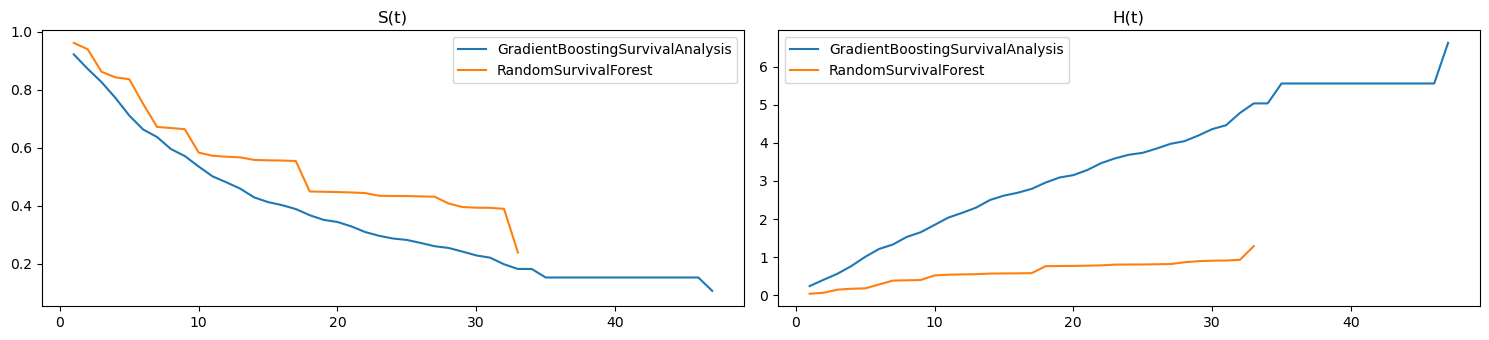

In [13]:
as_series = lambda y_pred: pd.Series(y_pred.y, index=y_pred.x)

fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

pd.DataFrame({n: as_series(m.predict_survival_function(X)[0]) 
              for n, m in zip(ss_names, ss_models)}) \
    .plot(kind='line', ax=ax[0])

pd.DataFrame({n: as_series(m.predict_cumulative_hazard_function(X)[0]) 
              for n, m in zip(ss_names, ss_models)}) \
    .plot(kind='line', ax=ax[1])

ax[0].set_title('S(t)')
ax[1].set_title('H(t)')

plt.tight_layout()

## Merged visualizations

Here are the visualizations merged.

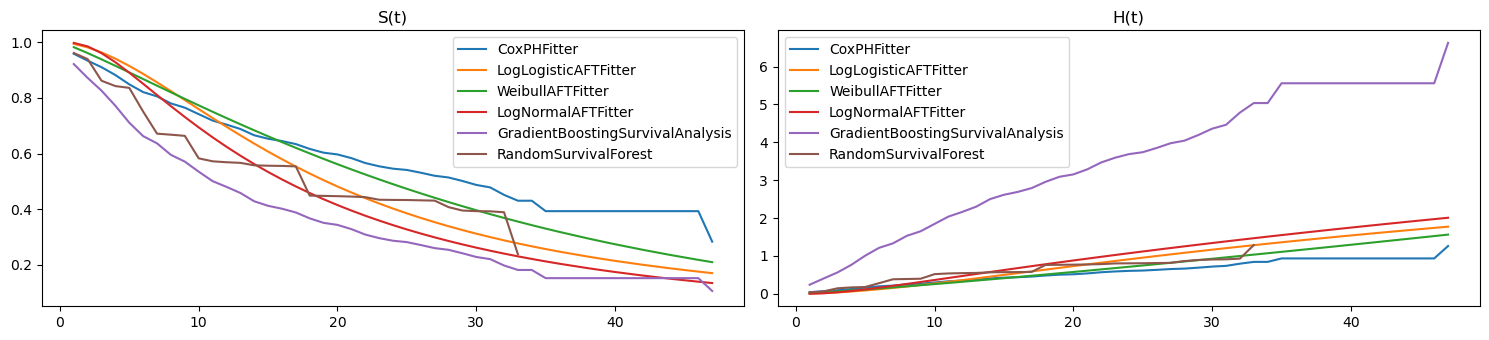

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

pd.DataFrame({n: m.lifelines_model.predict_survival_function(X)[0] 
              for n, m in zip(ll_names, ll_models)}) \
    .plot(kind='line', ax=ax[0])
pd.DataFrame({n: as_series(m.predict_survival_function(X)[0]) 
              for n, m in zip(ss_names, ss_models)}) \
    .plot(kind='line', ax=ax[0])

pd.DataFrame({n: m.lifelines_model.predict_cumulative_hazard(X)[0] 
              for n, m in zip(ll_names, ll_models)}) \
    .plot(kind='line', ax=ax[1])
pd.DataFrame({n: as_series(m.predict_cumulative_hazard_function(X)[0]) 
              for n, m in zip(ss_names, ss_models)}) \
    .plot(kind='line', ax=ax[1])

ax[0].set_title('S(t)')
ax[1].set_title('H(t)')

plt.tight_layout()

Here's the merged scores. It's interesting to note that the random survival forest model did worse than all the non-ensemble techniques.

In [15]:
pd.concat([ll_scores, ss_scores])

CoxPHFitter                         0.647557
LogLogisticAFTFitter                0.669827
WeibullAFTFitter                    0.639399
LogNormalAFTFitter                  0.662717
GradientBoostingSurvivalAnalysis    0.700963
RandomSurvivalForest                0.610181
dtype: float64

## Cumulative dynamic AUC performance

The time-dependent AUC performance may be calculated. First, let's shape the data for input into the lifeline models. We will split the data into training and testing to compute the validated time-dependent AUC performance.

In [16]:
from sklearn.model_selection import train_test_split

X = Xy[Xy.columns.drop(['T'])]
y = Xy['T']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=37)

yy_tr = np.array([(e, t) for e, t in zip(X_tr['E'], y_tr)], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
yy_te = np.array([(e, t) for e, t in zip(X_te['E'], y_te)], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

LLD = {
    'X_tr': X_tr,
    'X_te': X_te,
    'y_tr': y_tr,
    'y_te': y_te,
    'yy_tr': yy_tr,
    'yy_te': yy_te
}

X.shape, y.shape, X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((1808, 28), (1808,), (1446, 28), (1446,), (362, 28), (362,))

Let's shape the data for scikit-survival.

In [17]:
X = Xy[Xy.columns.drop(['T', 'E'])] \
    .assign(democracy=lambda d: d['democracy'].astype(np.float32))
y = np.array([(e, t) for e, t in zip(Xy['E'], Xy['T'])], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=37)

SSD = {
    'X_tr': X_tr,
    'X_te': X_te,
    'y_tr': y_tr,
    'y_te': y_te,
    'yy_tr': y_tr,
    'yy_te': y_te
}

X.shape, y.shape, X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((1808, 27), (1808,), (1446, 27), (1446,), (362, 27), (362,))

Now, let's train the models.

In [18]:
ll_models = [
    CoxRegression(penalizer=1e-5),
    LogLogisticRegression(penalizer=1e-5),
    WeibullRegression(penalizer=1e-5),
    LogNormalRegression(penalizer=1e-5),
]

ss_models = [
    GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=37),
    RandomSurvivalForest(n_estimators=500, n_jobs=-1, random_state=37)
]

for m in ll_models:
    m.fit(LLD['X_tr'], LLD['y_tr'])
    
for m in ss_models:
    m.fit(SSD['X_tr'], SSD['y_tr'])

Now we can validate the model using the cumulative dynamic AUC.

In [19]:
from sksurv.metrics import cumulative_dynamic_auc

def get_cumulative_dynamic_auc(y_tr, y_te, X_te, model, time=np.arange(1, 41), reverse=False):
    y_pred_te = model.predict(X_te)
    if reverse:
        y_pred_te = -y_pred_te
        
    auc, mean_auc = cumulative_dynamic_auc(
        y_tr, 
        y_te, 
        y_pred_te, 
        time
    )
    
    return {
        'auc': pd.Series(auc, index=time),
        'mean_auc': mean_auc
    }
    
LL_AUC = {n: get_cumulative_dynamic_auc(LLD['yy_tr'], LLD['yy_te'], LLD['X_te'], m, reverse=True) 
          for n, m in zip(ll_names, ll_models)}

SS_AUC = {n: get_cumulative_dynamic_auc(SSD['yy_tr'], SSD['yy_te'], SSD['X_te'], m) 
          for n, m in zip(ss_names, ss_models)}

Here are the plots of the cumulative dynamic AUC performances for each model.

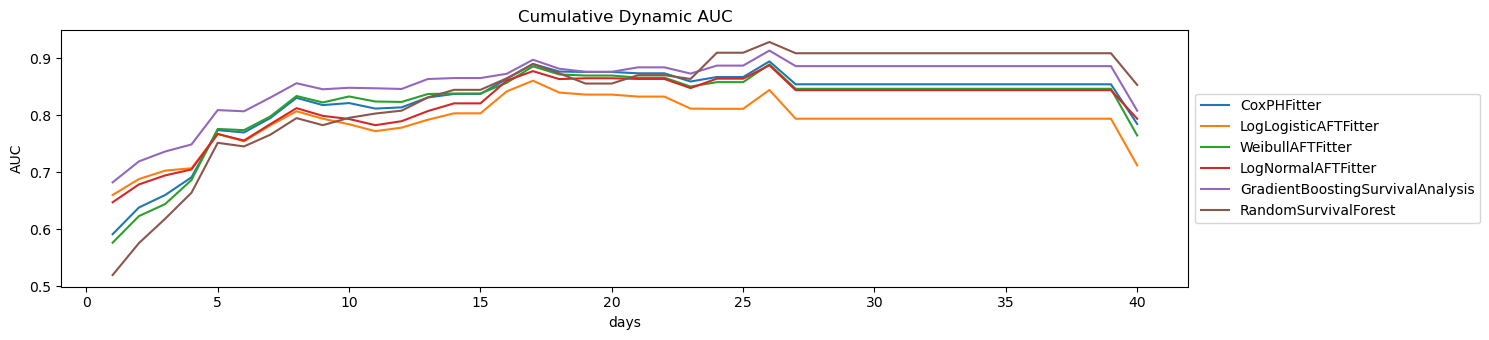

In [20]:
fig, ax = plt.subplots(figsize=(15, 3.5))

for n, r in {**LL_AUC, **SS_AUC}.items():
    r['auc'].plot(kind='line', ax=ax, label=n)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Cumulative Dynamic AUC')
ax.set_ylabel('AUC')
ax.set_xlabel('days')

plt.tight_layout()

These are the validated c-index performances of each model.

In [21]:
pd.Series({
    **{n: m.score(LLD['X_te'], LLD['y_te']) for n, m in zip(ll_names, ll_models)},
    **{n: m.score(SSD['X_te'], SSD['y_te']) for n, m in zip(ss_names, ss_models)}
})

CoxPHFitter                         0.629172
LogLogisticAFTFitter                0.664768
WeibullAFTFitter                    0.619007
LogNormalAFTFitter                  0.657695
GradientBoostingSurvivalAnalysis    0.692190
RandomSurvivalForest                0.586333
dtype: float64